**Глобальное тематическое моделирование (по трилогии целиком) + связь LDA и персонажей**

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import pymorphy3
import nltk
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords

# Основные инструменты LDA
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

# Визуализация и сглаживание
import pyLDAvis
import pyLDAvis.gensim
from scipy.ndimage import gaussian_filter1d
from collections import Counter

# Для разделения на train/test
from sklearn.model_selection import train_test_split

from collections import defaultdict, Counter

In [2]:
# Загружаем из первого ноутбука
with open('processed_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

segments = loaded_data['segments']
processed_segments = loaded_data['processed_segments']
book1_end = loaded_data['b1_end']
book2_end = loaded_data['b2_end']
my_mapping = loaded_data['my_mapping']
chapter_to_chunk_indices = loaded_data['chapter_to_chunk_indices']

In [ ]:
# Разделяем обработанные сегменты на 80% для обучения и 20% для теста
train_texts, test_texts = train_test_split(
    processed_segments, 
    test_size=0.20, 
    random_state=42
)

# Создаем словарь по обучающей выборке
train_id2word = corpora.Dictionary(train_texts)
train_id2word.filter_extremes(no_below=10, no_above=0.3) # Убираем слова, которые встречаются меньше чем в 10 главах и больше чем в 30% глав

# Создаем два корпуса
train_corpus = [train_id2word.doc2bow(text) for text in train_texts]
test_corpus = [train_id2word.doc2bow(text) for text in test_texts]

print(f"Обучающая выборка: {len(train_corpus)} чанков")
print(f"Тестовая выборка: {len(test_corpus)} чанков")

Обучающая выборка: 396 чанков
Тестовая выборка: 99 чанков


In [4]:
def find_optimal_topics_pro(train_corpus, test_corpus, train_id2word, train_texts, test_texts, topic_range):
    coherence_scores = []
    perplexities = []
    
    for num_topics in topic_range:
        # Обучаем на TRAIN
        model = gensim.models.LdaModel(
            corpus=train_corpus,
            id2word=train_id2word,
            num_topics=num_topics,
            passes=50,
            random_state=42
        )
        
        # Считаем Когерентность на TEST текстах
        cm = CoherenceModel(model=model, texts=processed_segments, dictionary=train_id2word, coherence='c_v')
        coherence_scores.append(cm.get_coherence())
        
        # Считаем перплексию на TEST корпусе
        perplexities.append(model.log_perplexity(test_corpus))
        
        print(f"Тем: {num_topics} | Coherence: {coherence_scores[-1]:.4f} | Perplexity: {perplexities[-1]:.4f}")
    
    return coherence_scores, perplexities

range_topics = range(8, 21, 2)
scores, perps = find_optimal_topics_pro(train_corpus, test_corpus, train_id2word, train_texts, test_texts, range_topics)

Тем: 8 | Coherence: 0.5157 | Perplexity: -7.3174
Тем: 10 | Coherence: 0.5171 | Perplexity: -7.4721
Тем: 12 | Coherence: 0.5197 | Perplexity: -7.5818
Тем: 14 | Coherence: 0.5133 | Perplexity: -7.7350
Тем: 16 | Coherence: 0.5091 | Perplexity: -7.8346
Тем: 18 | Coherence: 0.4974 | Perplexity: -7.9526
Тем: 20 | Coherence: 0.5104 | Perplexity: -8.0380


In [3]:
def create_dictionary_and_corpus(processed_segments, no_below=5, no_above=0.3):
    """Создаем словарь и корпус из обработанных сегментов"""
    full_id2word = corpora.Dictionary(processed_segments)
    print(f"Исходный словарь: {len(full_id2word)} уникальных слов")
    
    # Фильтруем слишком частые и слишком редкие слова
    full_id2word.filter_extremes(no_below=no_below, no_above=no_above)
    print(f"После фильтрации: {len(full_id2word)} уникальных слов")
    
    full_corpus = [full_id2word.doc2bow(segment) for segment in processed_segments]
    print(f"Создан корпус: {len(full_corpus)} документов")
    
    return full_id2word, full_corpus

full_id2word, full_corpus = create_dictionary_and_corpus(processed_segments)

Исходный словарь: 6274 уникальных слов
После фильтрации: 2277 уникальных слов
Создан корпус: 495 документов


In [4]:
top_words = []
for word_id, count in full_id2word.cfs.items():
    top_words.append((full_id2word[word_id], count))

# Сортируем по убыванию частоты и берем топ-30
top_words = sorted(top_words, key=lambda x: x[1], reverse=True)[:30]

print("Топ-30 слов в отфильтрованном корпусе:")
for word, count in top_words:
    print(f"{word}: {count}")

Топ-30 слов в отфильтрованном корпусе:
горлум: 764
гимли: 535
леголас: 445
бильбо: 440
фарамир: 399
боромир: 391
саруман: 383
гондор: 351
теоден: 316
конь: 309
гном: 308
эомер: 306
всадник: 305
конунг: 296
хранитель: 293
саурон: 289
берег: 261
элронд: 259
песня: 257
древень: 249
башня: 237
изенгард: 237
долина: 236
сын: 228
тьма: 228
путник: 224
сердце: 211
темнота: 210
склон: 206
денэтор: 205


In [5]:
# Создаем временный словарь из тех же сегментов, чтобы посмотреть, что у нас удалилось
temp_dict = corpora.Dictionary(processed_segments)

# Вычисляем порог в количестве документов
threshold_count = len(processed_segments) * 0.3

# Ищем слова, которые встречаются чаще, чем порог
removed_words = [
    temp_dict[word_id] 
    for word_id, doc_freq in temp_dict.dfs.items() 
    if doc_freq > threshold_count
]
print(sorted(removed_words))

['арагорн', 'ветер', 'вода', 'ворота', 'восток', 'враг', 'год', 'гора', 'гэндальф', 'дерево', 'друг', 'жизнь', 'запад', 'земля', 'камень', 'кольцо', 'край', 'лес', 'мерри', 'меч', 'мордор', 'небо', 'огонь', 'орк', 'пин', 'пора', 'река', 'свет', 'север', 'сила', 'солнце', 'сэм', 'тень', 'фродо', 'хоббит', 'хоббитания', 'хозяин', 'человек', 'эльф', 'язык']


In [53]:
def find_optimal_topics(full_corpus, full_id2word, processed_segments, topic_range=range(10, 25), passes=50, random_state=42, iterations=200):
    """Находим оптимальное количество тем для LDA модели."""
    coherence_scores = []
    
    for num_topics in topic_range:
        # Обучаем временную модель
        temp_model = gensim.models.LdaModel(
            corpus=full_corpus,
            id2word=full_id2word,
            num_topics=num_topics,
            passes=passes,
            random_state=random_state
        )
        
        # Считаем когерентность
        coherence_model = CoherenceModel(
            model=temp_model,
            texts=processed_segments,
            dictionary=full_id2word,
            coherence='c_v'
        )
        
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f"Тем: {num_topics}, Когерентность: {coherence_score:.4f}")
    
    # Выбираем лучшее количество тем
    best_idx = coherence_scores.index(max(coherence_scores))
    best_num_topics = topic_range[best_idx]
    print(f"\nРекомендуемое количество тем: {best_num_topics}")
    
    return best_num_topics, coherence_scores

best_num_topics, coherence_scores = find_optimal_topics(
    full_corpus, 
    full_id2word, 
    processed_segments, 
    topic_range=range(10, 25)
)

Тем: 10, Когерентность: 0.5288
Тем: 11, Когерентность: 0.5232
Тем: 12, Когерентность: 0.5228
Тем: 13, Когерентность: 0.5064
Тем: 14, Когерентность: 0.4994
Тем: 15, Когерентность: 0.5228
Тем: 16, Когерентность: 0.5388
Тем: 17, Когерентность: 0.5389
Тем: 18, Когерентность: 0.5317
Тем: 19, Когерентность: 0.5044
Тем: 20, Когерентность: 0.5267
Тем: 21, Когерентность: 0.5076
Тем: 22, Когерентность: 0.5218
Тем: 23, Когерентность: 0.5085
Тем: 24, Когерентность: 0.5088

Рекомендуемое количество тем: 17


In [ ]:
# Симметричное распределение
model_symmetric = LdaModel(
    corpus=full_corpus,
    id2word=full_id2word,
    num_topics=17,
    passes=50,
    random_state=42,
    iterations=200,
    alpha='symmetric',  
    eta='symmetric'
)

# Автоматическое определение
model_auto = LdaModel(
    corpus=full_corpus,
    id2word=full_id2word,
    num_topics=17,
    passes=50,
    random_state=42,
    iterations=200,
    alpha='auto',
    eta='auto'
)

# Асимметричное
model_asymmetric = LdaModel(
    corpus=full_corpus,
    id2word=full_id2word,
    num_topics=17,
    passes=50,
    random_state=42,
    iterations=200,
    alpha='asymmetric',  
    eta='symmetric'
)

# Ручная настройка
model_manual = LdaModel(
    corpus=full_corpus,
    id2word=full_id2word,
    num_topics=17,
    passes=50,
    random_state=42,
    iterations=200,
    alpha=0.1, 
    eta=0.01 
)

# Основано на исследованиях
model_research = LdaModel(
    corpus=full_corpus,
    id2word=full_id2word,
    num_topics=17,
    passes=50,
    random_state=42,
    iterations=200,
    alpha=1/17, 
    eta=0.01
)

model_customized = LdaModel(
    corpus=full_corpus,
    id2word=full_id2word,
    num_topics=17,
    passes=50,
    random_state=42,
    iterations=200,
    alpha='auto',            
    eta=0.01
)

# Функция для сравнения моделей
def evaluate_models(models_dict, corpus, texts, dictionary):
    """Оцениваем несколько моделей по когерентности"""
    results = []
    
    for name, model in models_dict.items():
        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherence_model.get_coherence()
        perp = model.log_perplexity(corpus)
        results.append((name, coherence, perp))
        
        # Выводим топ-слов для 17 тем для сравнения
        print(f"\n{name}:")
        print(f"  Когерентность: {coherence:.4f}, Перплексия: {perp:.4f}")
        for topic_id in range(min(17, model.num_topics)):
            words = [word for word, _ in model.show_topic(topic_id, topn=8)]
            print(f"  Тема {topic_id}: {', '.join(words)}")
    
    # Сортируем по когерентности
    results.sort(key=lambda x: x[1], reverse=True)
    print(f"\nЛучшая модель: {results[0][0]} (когерентность: {results[0][1]:.4f})")
    
    return results

# Сравниваем все модели
models = {
    'symmetric': model_symmetric,
    'auto': model_auto,
    'asymmetric': model_asymmetric,
    'manual': model_manual,
    'research': model_research,
    'customized': model_customized
}

results = evaluate_models(models, full_corpus, processed_segments, full_id2word)


symmetric:
  Когерентность: 0.5349, Перплексия: -6.4305
  Тема 0: лориэн, хранитель, владычица, хэлдар, леголас, галадриэль, гном, путник
  Тема 1: саруман, древень, изенгард, онт, гимли, леголас, ристания, имя
  Тема 2: фарамир, денэтор, берегонд, гондор, сын, боромир, город, наместник
  Тема 3: конь, всадник, углук, войско, битва, город, воин, назгул
  Тема 4: гном, саурон, эовин, сказание, царевна, дарин, имя, сын
  Тема 5: гимли, леголас, мория, путник, боромир, маг, гном, хранитель
  Тема 6: бильбо, торба, торбинс, карман, рождение, гаральд, лякошель, норгорд
  Тема 7: склон, долина, трава, холм, тропа, вершина, всадник, тракт
  Тема 8: горлум, прелесть, верёвка, скала, палец, нос, воздух, шея
  Тема 9: пони, всадник, пригорье, наркисс, кроттон, трактир, тракт, лавр
  Тема 10: бильбо, элронд, песня, раздол, совет, гном, корабль, зеркало
  Тема 11: гондор, боромир, саурон, элронд, исилдур, совет, сын, минас_тирит
  Тема 12: корона, колено, трон, звезда, море, гнилоуст, чертог, гон

In [6]:
# Обучаем финальную модель
full_lda_model = gensim.models.LdaModel(corpus=full_corpus,
                                   id2word=full_id2word,
                                   num_topics=17,
                                   passes=50,
                                   random_state=42,
                                   alpha='symmetric', 
                                   eta='symmetric', 
                                   iterations=200)

In [7]:
topics = full_lda_model.print_topics(num_words=20)
for topic in topics:
  print(topic)

(0, '0.018*"денэтор" + 0.015*"гондор" + 0.011*"саурон" + 0.011*"минас_тирит" + 0.010*"берегонд" + 0.009*"город" + 0.009*"врата" + 0.009*"теоден" + 0.008*"воин" + 0.008*"сын" + 0.007*"тысяча" + 0.007*"чертог" + 0.007*"подмога" + 0.007*"гнилоуст" + 0.007*"совет" + 0.007*"всадник" + 0.007*"наместник" + 0.006*"войско" + 0.006*"фарамир" + 0.006*"оружие"')
(1, '0.030*"коридор" + 0.025*"маг" + 0.023*"путник" + 0.021*"хранитель" + 0.021*"боромир" + 0.019*"мория" + 0.018*"верёвка" + 0.016*"жезл" + 0.013*"грышнак" + 0.013*"тьма" + 0.012*"мост" + 0.011*"гимли" + 0.010*"пещера" + 0.010*"барлог" + 0.009*"арка" + 0.009*"пол" + 0.009*"зал" + 0.009*"комната" + 0.008*"тишина" + 0.008*"спутник"')
(2, '0.067*"бильбо" + 0.015*"торбинс" + 0.013*"всадник" + 0.013*"песня" + 0.012*"торба" + 0.009*"маг" + 0.007*"пиво" + 0.007*"камин" + 0.007*"гном" + 0.007*"совет" + 0.007*"брендизайк" + 0.006*"норгорд" + 0.006*"трактир" + 0.006*"гаральд" + 0.006*"рождение" + 0.006*"крол" + 0.006*"карман" + 0.006*"повозка" + 0.

In [8]:
# Вычисляем перплексию
full_lda_model.log_perplexity(full_corpus)

np.float64(-6.954493650288594)

In [9]:
# Вычисляем когерентность
coherence_model_lda = CoherenceModel(model=full_lda_model, texts=processed_segments, dictionary=full_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.4642150028380311


In [10]:
# Вычисляем разнообразие тем
def calculate_topic_diversity(topic_model):
    # Достаем топ-25 слов для каждой темы
    topics = topic_model.get_topics()
    top_words = []
    for topic_id in range(len(topics)):
        # Получаем только слова (без весов)
        words = [word for word, _ in topic_model.show_topic(topic_id, topn=25)]
        top_words.extend(words)
    
    # Считаем процент уникальных слов среди всех извлеченных
    unique_words = set(top_words)
    diversity = len(unique_words) / len(top_words)
    return diversity

diversity_score = calculate_topic_diversity(full_lda_model)
print(f"Topic Diversity: {diversity_score:.4f}")

Topic Diversity: 0.6141


In [11]:
# Делаем анализ фоновых слов
def analyze_background_words(full_lda_model, topn=20, threshold=0.5):
    """
    topn: сколько первых слов брать из каждой темы
    threshold: в какой доле тем должно встретиться слово, чтобы стать фоновым
    """
    all_top_words = []
    num_topics = full_lda_model.num_topics
    
    # Собираем топ-слова изо всех тем
    for i in range(num_topics):
        words = [word for word, prob in full_lda_model.show_topic(i, topn=topn)]
        all_top_words.extend(words)
    
    # Считаем, в скольких темах появилось каждое слово
    word_counts = Counter(all_top_words)
    
    background_words = [
        (word, count) for word, count in word_counts.items() 
        if count >= num_topics * threshold
    ]
    
    print(f"Анализ фоновых слов (порог: {threshold*100}%)")
    if not background_words:
        print("Фоновых слов не обнаружено.")
    else:
        for word, count in sorted(background_words, key=lambda x: x[1], reverse=True):
            print(f"Слово '{word}' встречается в {count} темах из {num_topics}")
            
    return background_words

bg_words = analyze_background_words(full_lda_model)

Анализ фоновых слов (порог: 50.0%)
Фоновых слов не обнаружено.


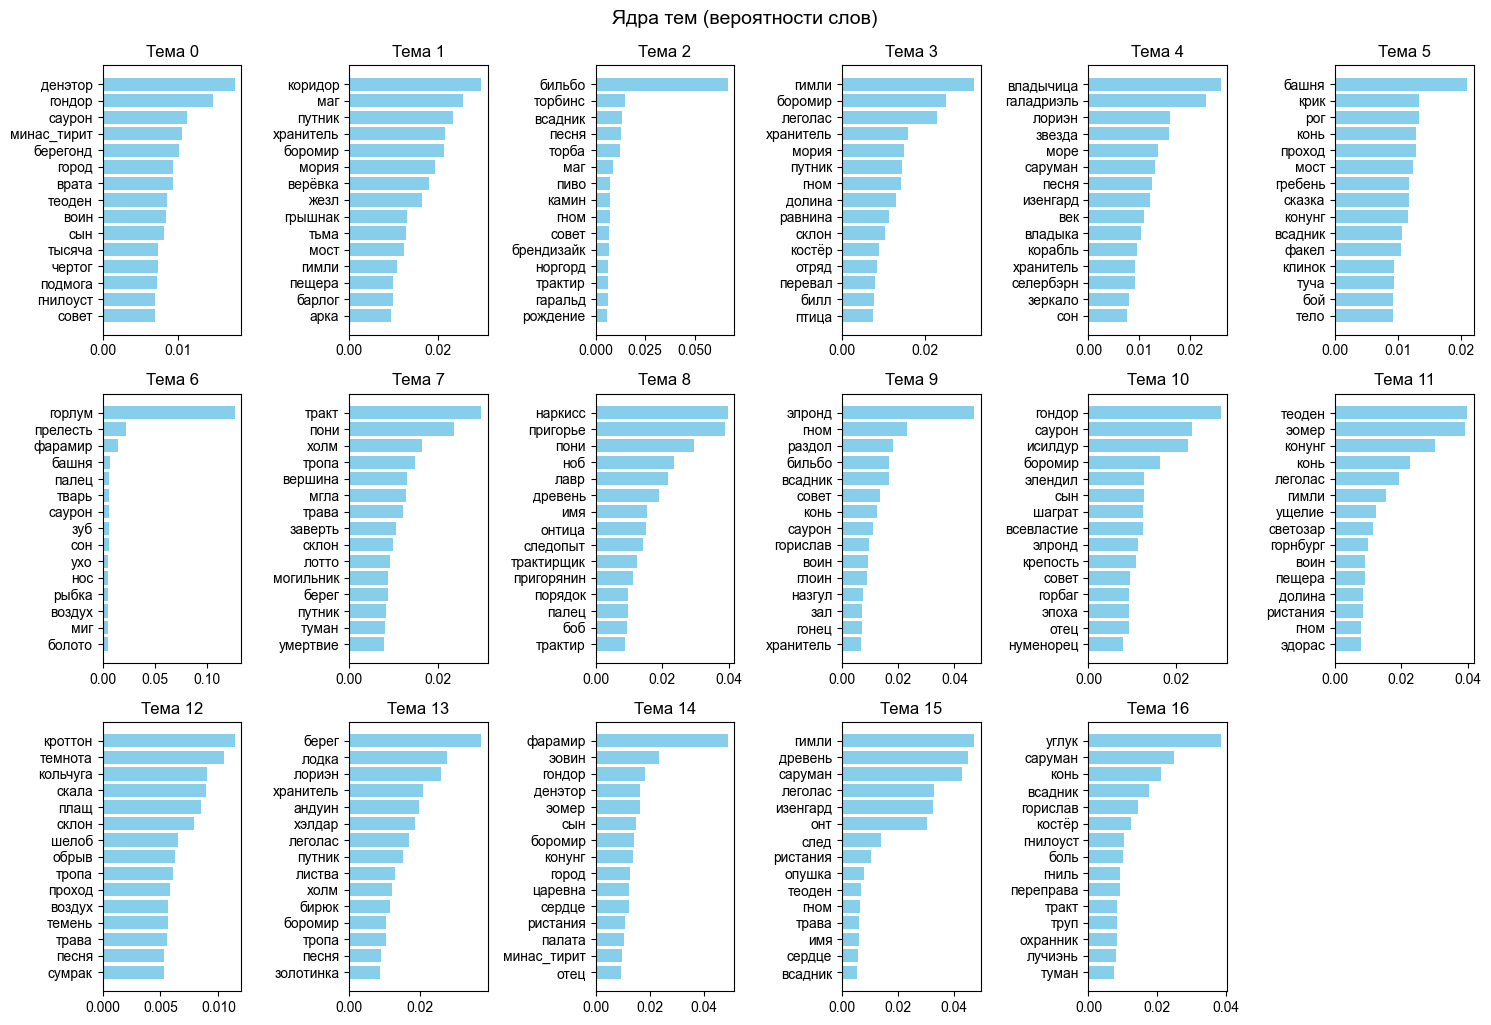

In [12]:
def plot_topic_kernels(full_lda_model, num_words=15):
    """Визуализация распределения вероятностей слов в ядре каждой темы"""
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.figure(figsize=(15, 10))
    
    for i in range(full_lda_model.num_topics):
        # Получаем слова и их вероятности
        words_probs = full_lda_model.show_topic(i, topn=num_words)
        words = [wp[0] for wp in words_probs]
        probs = [wp[1] for wp in words_probs]
        
        plt.subplot(3, 6, i+1)
        plt.barh(words, probs, color='skyblue')
        plt.title(f"Тема {i}")
        plt.gca().invert_yaxis()
        
    plt.tight_layout()
    plt.suptitle("Ядра тем (вероятности слов)", fontsize=14, y=1.02)
    plt.show()

plot_topic_kernels(full_lda_model)

In [13]:
# Сопоставление выделенных тем с сюжетом книги и проверка точности работы модели (валидация)
# Даем названия темам
topic_names = {
    0: "Лотлориэн: Приют эльфов", 
    1: "Фангорн и Гнев Энтов",
    2: "Минас Тирит: Наместник и воины",
    3: "Сражения и Назгулы",
    4: "Легенды о народе Дарина",
    5: "Мория: Путь во тьме",
    6: "Праздник в Шире",
    7: "География: Дикие земли",
    8: "Преследование Смеагола",
    9: "Бри: У Наркисса",
    10: "Раздол: Зеркало и Совет",
    11: "Совет: История Кольца",
    12: "Коронация и Тронный зал",
    13: "Рохан: Всадники и Конунг",
    14: "Братство на Андуине",
    15: "Палаты Исцеления",
    16: "Крепость Кирит Унгол"
}

doc_topics = []
for i, doc in enumerate(full_corpus):
    topic_dist = full_lda_model.get_document_topics(doc)
    dominant = max(topic_dist, key=lambda x: x[1])
    doc_topics.append((i, dominant[0], dominant[1]))

# Выводим каждую тему с примерами
for topic_id in range(full_lda_model.num_topics):
    print(f"\nТема {topic_id}: {topic_names[topic_id]}")
    
    # Ключевые слова
    words = [w[0] for w in full_lda_model.show_topic(topic_id, topn=16)]
    print(f"Слова: {', '.join(words)}")
    
    # Примеры сегментов
    examples = sorted([d for d in doc_topics if d[1] == topic_id], 
                     key=lambda x: x[2], reverse=True)[:2]
    
    print(f"Примеры ({len([d for d in doc_topics if d[1] == topic_id])} сегментов):")
    for idx, (seg_id, _, prob) in enumerate(examples, 1):
        print(f"  {idx}. Сегмент #{seg_id} ({prob:.1%}): {' '.join(processed_segments[seg_id][:20])}...")


Тема 0: Лотлориэн: Приют эльфов
Слова: денэтор, гондор, саурон, минас_тирит, берегонд, город, врата, теоден, воин, сын, тысяча, чертог, подмога, гнилоуст, совет, всадник
Примеры (42 сегментов):
  1. Сегмент #375 (99.4%): кольценосец главарь назгул жало отчаяние гэндальф противник денэтор твердыня поле бой сила пин гэндальф испуг сила гэндальф сила прорицание муж...
  2. Сегмент #341 (99.3%): врата спутник гном гора чужестранец подмога престол денэтор гэндальф рост ингольд битва опасность доля изенгард пин доблесть муж муж ингольд...

Тема 1: Фангорн и Гнев Энтов
Слова: коридор, маг, путник, хранитель, боромир, мория, верёвка, жезл, грышнак, тьма, мост, гимли, пещера, барлог, арка, пол
Примеры (17 сегментов):
  1. Сегмент #140 (99.4%): арагорн мёртвый хоббит фродо грудь синяк хоббит пощада мифрил усмешка арагорн общество трактир толстяк наркисс орк бык счастие фродо грудь...
  2. Сегмент #130 (99.2%): заклинание друг друг мэллона ворота простота дружелюбие ворота гэндальф ворота ступен

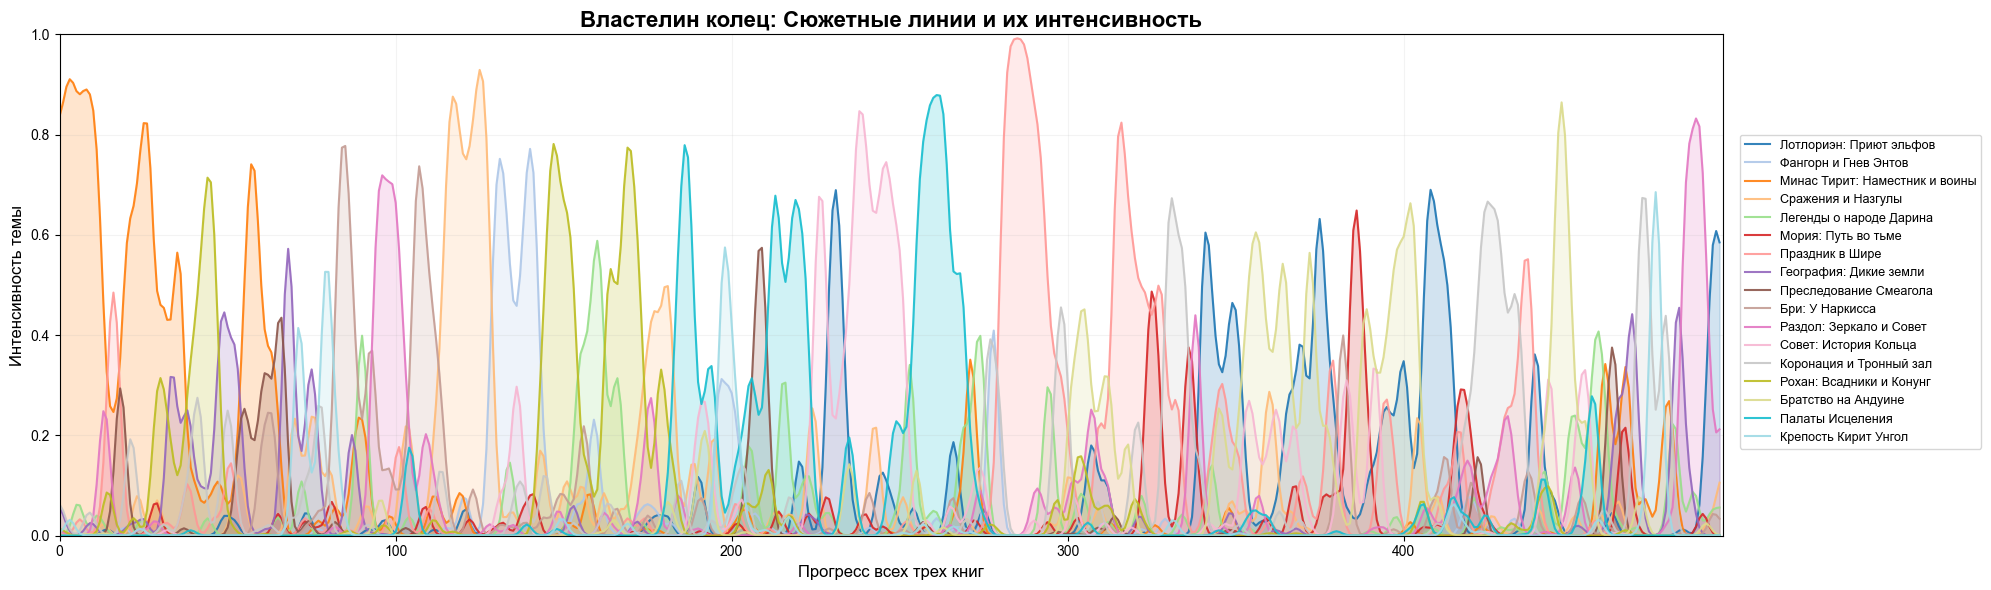

In [14]:
# Создаем график интенсивности тем
# Извлекаем веса тем для каждого сегмента
num_topics = full_lda_model.num_topics
num_segments = len(full_corpus)

# Создаем пустую матрицу
topic_matrix = np.zeros((num_segments, num_topics))
for seg_idx, doc in enumerate(full_corpus):
    # Получаем вероятности всех тем для текущего документа
    topic_dist = full_lda_model.get_document_topics(doc, minimum_probability=0)
    for topic_id, prob in topic_dist:
        topic_matrix[seg_idx, topic_id] = prob

# Даем названия нашим темам
topic_names = {
    0: "Лотлориэн: Приют эльфов", 
    1: "Фангорн и Гнев Энтов",
    2: "Минас Тирит: Наместник и воины",
    3: "Сражения и Назгулы",
    4: "Легенды о народе Дарина",
    5: "Мория: Путь во тьме",
    6: "Праздник в Шире",
    7: "География: Дикие земли",
    8: "Преследование Смеагола",
    9: "Бри: У Наркисса",
    10: "Раздол: Зеркало и Совет",
    11: "Совет: История Кольца",
    12: "Коронация и Тронный зал",
    13: "Рохан: Всадники и Конунг",
    14: "Братство на Андуине",
    15: "Палаты Исцеления",
    16: "Крепость Кирит Унгол"
}

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.figure(figsize=(20, 6))
colors = plt.cm.tab20(np.linspace(0, 1, num_topics))

# Сглаживание, чтобы убрать резкие колебания
sigma = 1.5

for topic_id in range(num_topics):
    # Делаем линии плавными
    smoothed_data = gaussian_filter1d(topic_matrix[:, topic_id], sigma=sigma)
    
    plt.fill_between(range(num_segments), 
                     smoothed_data, 
                     alpha=0.2, 
                     color=colors[topic_id])
    
    plt.plot(smoothed_data, 
             color=colors[topic_id],
             linewidth=1.5,
             alpha=0.9,
             label=topic_names[topic_id])

plt.title('Властелин колец: Сюжетные линии и их интенсивность', 
          fontsize=16, fontweight='bold')

plt.xlabel('Прогресс всех трех книг', fontsize=12)
plt.ylabel('Интенсивность темы', fontsize=12)

plt.legend(loc='upper left', 
           bbox_to_anchor=(1.01, 0.8),
           borderaxespad=0,
           fontsize=9)

plt.grid(alpha=0.15)
plt.ylim(0, 1)
plt.xlim(0, num_segments)

plt.tight_layout()
plt.show()

In [15]:
# Сравнение результатов LDA с базовой линией (Baseline)
# Случайное распределение тем
np.random.seed(42)
random_topics = np.random.randint(0, 16, size=len(segments))
print("Распределение тем при случайном назначении:")
random_dist = Counter(random_topics)
for topic_id, count in sorted(random_dist.items()):
    print(f"  Тема {topic_id}: {count} сегментов ({count/len(segments)*100:.1f}%)")

# Реальное распределение из LDA
real_topics = np.argmax(topic_matrix, axis=1)
real_dist = Counter(real_topics)
print(f"\nРеальное распределение из LDA:")
for topic_id, count in sorted(real_dist.items()):
    print(f"  Тема {topic_id}: {count} сегментов ({count/len(segments)*100:.1f}%)")

# Энтропия
def entropy(distribution):
    probs = np.array(list(distribution.values())) / sum(distribution.values())
    return -np.sum(probs * np.log2(probs + 1e-10))

print(f"\nЭнтропия случайного распределения: {entropy(random_dist):.3f}")
print(f"Энтропия LDA распределения: {entropy(real_dist):.3f}")

Распределение тем при случайном назначении:
  Тема 0: 2 сегментов (3.2%)
  Тема 1: 2 сегментов (3.2%)
  Тема 2: 5 сегментов (8.1%)
  Тема 3: 3 сегментов (4.8%)
  Тема 4: 5 сегментов (8.1%)
  Тема 5: 3 сегментов (4.8%)
  Тема 6: 5 сегментов (8.1%)
  Тема 7: 5 сегментов (8.1%)
  Тема 8: 2 сегментов (3.2%)
  Тема 9: 3 сегментов (4.8%)
  Тема 10: 5 сегментов (8.1%)
  Тема 11: 7 сегментов (11.3%)
  Тема 12: 3 сегментов (4.8%)
  Тема 13: 4 сегментов (6.5%)
  Тема 14: 4 сегментов (6.5%)
  Тема 15: 4 сегментов (6.5%)

Реальное распределение из LDA:
  Тема 0: 42 сегментов (67.7%)
  Тема 1: 17 сегментов (27.4%)
  Тема 2: 43 сегментов (69.4%)
  Тема 3: 29 сегментов (46.8%)
  Тема 4: 24 сегментов (38.7%)
  Тема 5: 12 сегментов (19.4%)
  Тема 6: 43 сегментов (69.4%)
  Тема 7: 17 сегментов (27.4%)
  Тема 8: 12 сегментов (19.4%)
  Тема 9: 25 сегментов (40.3%)
  Тема 10: 28 сегментов (45.2%)
  Тема 11: 37 сегментов (59.7%)
  Тема 12: 40 сегментов (64.5%)
  Тема 13: 31 сегментов (50.0%)
  Тема 14: 42 с

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(full_lda_model,
                              full_corpus,
                              full_id2word,
                              mds="mmds",
                              R=30 # Кол-во слов для каждого топика
                              )
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.196585  0.083633       1        1  9.057694
14     0.041497  0.338816       2        1  8.559325
0      0.062707  0.206660       3        1  8.333651
2     -0.316092  0.167223       4        1  7.630743
15    -0.047047 -0.180344       5        1  7.494963
3      0.113161 -0.101404       6        1  7.377828
12    -0.179156 -0.214334       7        1  7.190210
11    -0.102565  0.272976       8        1  7.139069
10     0.224753  0.270497       9        1  6.050781
13     0.296377 -0.188521      10        1  5.910523
4     -0.015595  0.041755      11        1  5.107216
9      0.282379  0.124804      12        1  4.782792
1      0.176517 -0.270324      13        1  3.769284
7     -0.302560 -0.163533      14        1  3.463904
5      0.257726  0.014841      15        1  3.351834
16    -0.284710 -0.026213      16        1  2.453475
8     -0.010806 -0.376530      17        1  2.326708, topic_info=         Term        Freq       Total Category  logprob  loglift
284    горлум  737.000000  737.000000  Default  30.0000  30.0000
3      бильбо  426.000000  426.000000  Default  29.0000  29.0000
2182  фарамир  385.000000  385.000000  Default  28.0000  28.0000
1519    гимли  520.000000  520.000000  Default  27.0000  27.0000
1885  древень  242.000000  242.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
92        маг    9.710317  182.600346  Topic17  -5.0177   0.8266
377      толк    7.695935   46.268794  Topic17  -5.2502   1.9669
836   постель    7.743134   49.775107  Topic17  -5.2441   1.9000
462    корень    7.946779   69.332005  Topic17  -5.2181   1.5946
1936      онт    8.309004  154.451327  Topic17  -5.1735   0.8382

[1034 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1728      6  0.086678   аллея
1728      8  0.173356   аллея
1728     11  0.520068   аллея
1728     14  0.173356   аллея
1363      2  0.195369   алмаз
...     ...       ...     ...
862      10  0.968160   ясень
158       4  0.860814   яство
1775      6  0.151018  ятаган
1775     13  0.755092  ятаган
1775     15  0.050339  ятаган

[3531 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 15, 1, 3, 16, 4, 13, 12, 11, 14, 5, 10, 2, 8, 6, 17, 9])

Визуализация доказывает, что модель успешно реконструировала структуру произведения: темы автономны, легко интерпретируемы по ключевым словам и соответствуют реальной значимости сюжетных линий в романе.

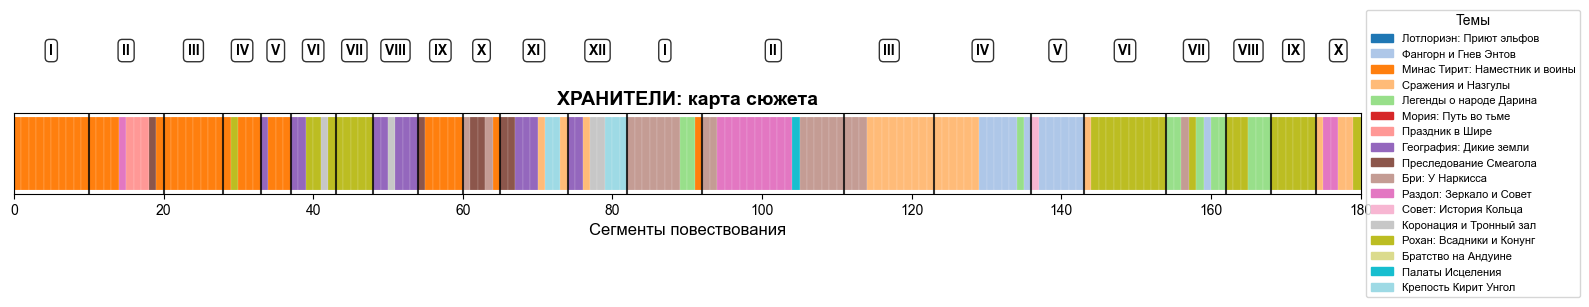

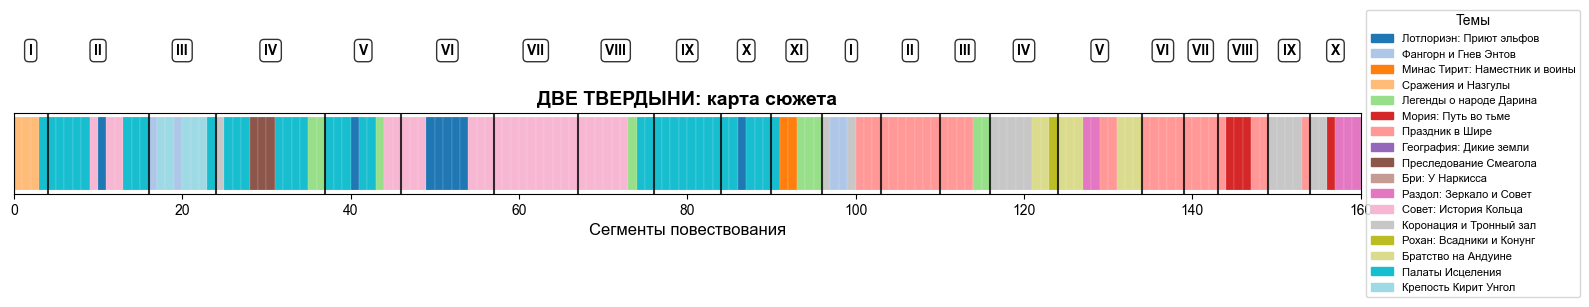

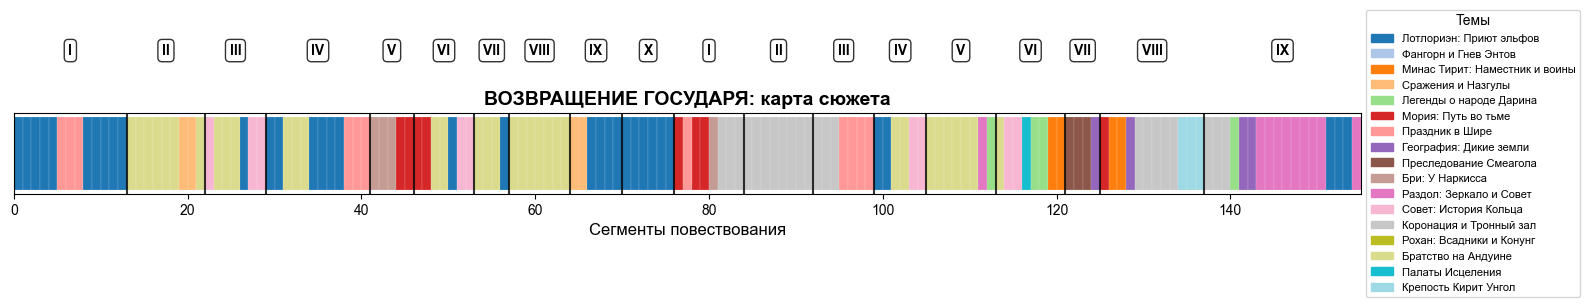

In [17]:
# Рисуем графики с картами сюжета!
dominant_topics = np.argmax(topic_matrix, axis=1)

topic_names = [
    "Лотлориэн: Приют эльфов", 
    "Фангорн и Гнев Энтов",
    "Минас Тирит: Наместник и воины",
    "Сражения и Назгулы",
    "Легенды о народе Дарина",
    "Мория: Путь во тьме",
    "Праздник в Шире",
    "География: Дикие земли",
    "Преследование Смеагола",
    "Бри: У Наркисса",
    "Раздол: Зеркало и Совет",
    "Совет: История Кольца",
    "Коронация и Тронный зал",
    "Рохан: Всадники и Конунг",
    "Братство на Андуине",
    "Палаты Исцеления",
    "Крепость Кирит Унгол"
]

# Названия книг для заголовков
book_titles = ['ХРАНИТЕЛИ', 'ДВЕ ТВЕРДЫНИ', 'ВОЗВРАЩЕНИЕ ГОСУДАРЯ']
idx1 = chapter_to_chunk_indices[22]  # Начало "Двух твердынь"
idx2 = chapter_to_chunk_indices[43]  # Начало "Возвращения государя"
idx_total = len(dominant_topics)
books_map = [
    (book_titles[0], 0, idx1),
    (book_titles[1], idx1, idx2),
    (book_titles[2], idx2, idx_total)
]

for book_name, start, end in books_map:
    if start >= end: continue

    colors = plt.cm.tab20(np.linspace(0, 1, num_topics))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']

    plt.figure(figsize=(16, 4))
    
    # Отрисовка полосок
    for i in range(start, end):
        t_id = dominant_topics[i]
        plt.barh(0, 1.0, left=i-start, height=0.5, 
                 color=colors[t_id], edgecolor='white', linewidth=0.1)

    # Линии глав 
    current_book_chapters = [
        (ch_idx, ch_pos) for ch_idx, ch_pos in enumerate(chapter_to_chunk_indices) 
        if start <= ch_pos < end
    ]

    for i, (ch_idx, ch_pos) in enumerate(current_book_chapters):
        # Вертикальная линия
        plt.axvline(x=ch_pos-start, color='black', linestyle='-', linewidth=1.5, alpha=0.8)
        
        # Определение номера главы для подписи
        chapter_text = segments[ch_idx]
        match = re.search(r'Глава\s+([IVX]+|\d+)', chapter_text, re.IGNORECASE)
        label = match.group(1).upper() if match else str(i+1)
        
        # Вычисление середины главы для текста
        if i < len(current_book_chapters) - 1:
            next_pos = current_book_chapters[i+1][1]
        else:
            next_pos = end
        mid = ((ch_pos - start) + (next_pos - start)) / 2
        
        # Подпись главы
        plt.text(mid, 0.7, label, ha='center', va='center',
                 fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    plt.title(f'{book_name}: карта сюжета', fontweight='bold', fontsize=14)
    plt.xlabel('Сегменты повествования', fontsize=12)
    plt.yticks([]) 
    plt.xlim(0, end - start) # Ограничиваем график строго по длине книги
    
    # Легенда
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[k]) for k in range(len(topic_names))]
    plt.legend(handles, topic_names, loc='center left', bbox_to_anchor=(1, 0.5), 
               title="Темы", fontsize=8)
    
    plt.tight_layout()
    plt.show()

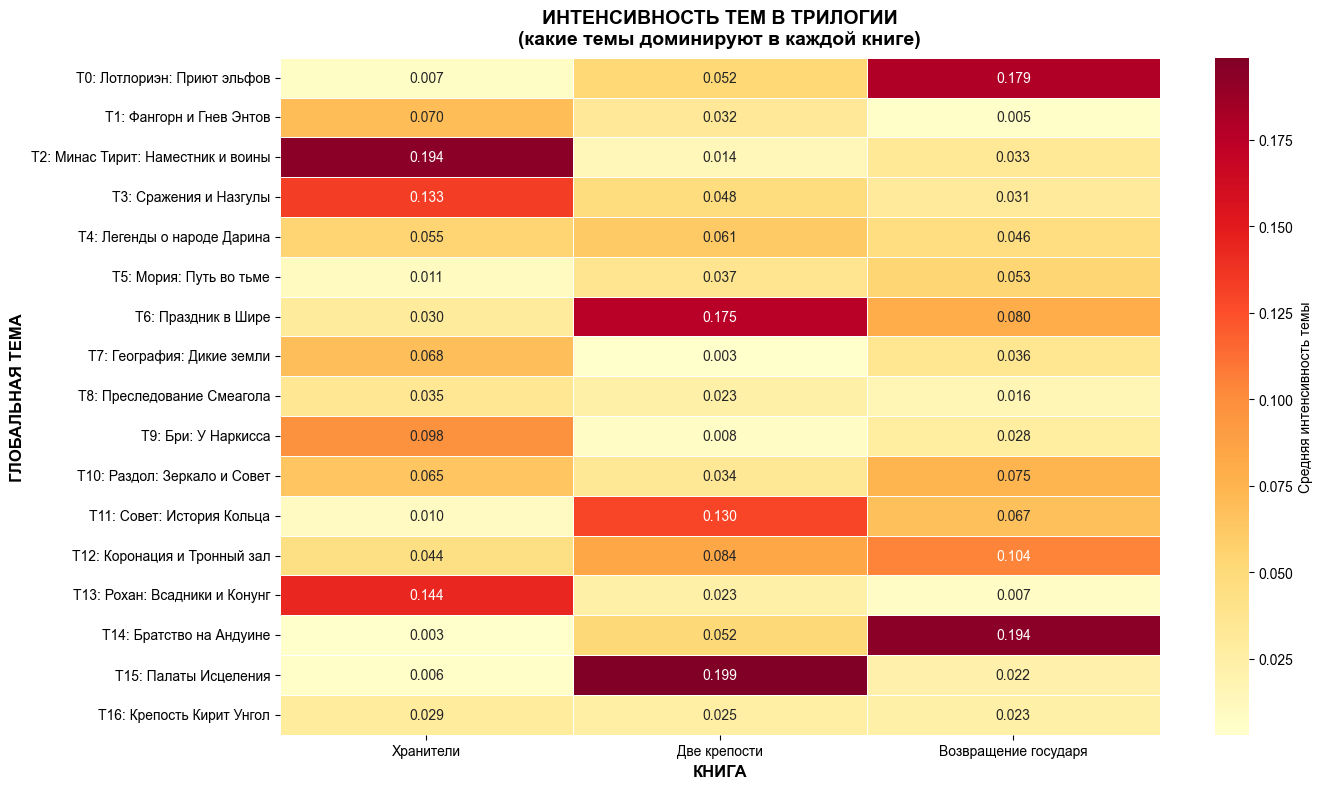

In [18]:
# Рисуем Heatmap
num_topics = len(topic_names)
coverage = np.zeros((num_topics, 3))

# Функция для безопасного расчета среднего
def get_avg_coverage(start, end):
    if start >= end: return np.zeros(num_topics)
    # Считаем среднее по столбцам
    return topic_matrix[start:end].mean(axis=0)

# Заполняем столбцы для каждой книги
coverage[:, 0] = get_avg_coverage(0, idx1)
coverage[:, 1] = get_avg_coverage(idx1, idx2)
coverage[:, 2] = get_avg_coverage(idx2, idx_total)

# Создаем DataFrame для визуализации
df_coverage = pd.DataFrame(
    coverage,
    columns=['Хранители', 'Две крепости', 'Возвращение государя'],
    index=[f"Т{i}: {name}" for i, name in enumerate(topic_names)]
)

# Рисуем Heatmap
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.figure(figsize=(14, 8))
sns.heatmap(df_coverage, 
            annot=True, 
            fmt='.3f', 
            cmap='YlOrRd',
            linewidths=0.5,
            cbar_kws={'label': 'Средняя интенсивность темы'})

plt.title('ИНТЕНСИВНОСТЬ ТЕМ В ТРИЛОГИИ\n(какие темы доминируют в каждой книге)', 
          fontsize=14, fontweight='bold', pad=10)
plt.xlabel('КНИГА', fontsize=12, fontweight='bold')
plt.ylabel('ГЛОБАЛЬНАЯ ТЕМА', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Посмотрим связь LDA и персонажей!

In [19]:
# Создаем черный список для локаций и имен нарицательных
blacklist = [
    'средиземье', 'хоббитания', 'лихолесье', 'осгилиат', 'пригорье',
    'мордор', 'ривенделл', 'шир', 'рохан', 'гондор', 'арнор', 'раздол',
    'минас_тирит', 'изенгард', 'лориэн', 'мория', 'хоббит', 'ристания', 'орк'
]

# Извлекаем все уникальные имена
all_entities = set(my_mapping.values())

# Оставляем только целевых персонажей
target_heroes = {name for name in all_entities if name not in blacklist}

print(f"Было сущностей: {len(all_entities)}")
print(f"Осталось героев: {len(target_heroes)}")

Было сущностей: 201
Осталось героев: 185


In [20]:
# Посмотрим, в какой теме герой упоминается чаще всего
topic_names = [
    "Лотлориэн: Приют эльфов", 
    "Фангорн и Гнев Энтов",
    "Минас Тирит: Наместник и воины",
    "Сражения и Назгулы",
    "Легенды о народе Дарина",
    "Мория: Путь во тьме",
    "Праздник в Шире",
    "География: Дикие земли",
    "Преследование Смеагола",
    "Бри: У Наркисса",
    "Раздол: Зеркало и Совет",
    "Совет: История Кольца",
    "Коронация и Тронный зал",
    "Рохан: Всадники и Конунг",
    "Братство на Андуине",
    "Палаты Исцеления",
    "Крепость Кирит Унгол"
]

def connect_heroes_and_topics(processed_segments, topic_matrix, target_heroes_set, topic_names):
    # Определяем доминирующую тему для каждого чанка
    dominant_topics = np.argmax(topic_matrix, axis=1)
    
    # Словарь: Герой -> Список тем, в контексте которых он появлялся
    hero_topic_map = defaultdict(list)
    
    # Проходим по всем чанкам
    for tokens, topic_id in zip(processed_segments, dominant_topics):
        
        # Находим уникальных героев в текущем чанке
        heroes_in_chunk = set(tokens).intersection(target_heroes_set)
        
        # Каждому найденному герою приписываем тему этого чанка
        for hero in heroes_in_chunk:
            hero_topic_map[hero].append(topic_id)
            
    results = []
    
    for hero, topics in hero_topic_map.items():
        total_mentions = len(topics)
        if total_mentions < 10: continue # Игнорируем редких персонажей
            
        # Считаем, как часто герой попадал в каждую тему
        counts = Counter(topics)
        
        # Самая частая тема
        top_topic_id, count = counts.most_common(1)[0]
        top_topic_name = topic_names[top_topic_id]
        share = (count / total_mentions) * 100
        
        row = {
            'Герой': hero.capitalize(),
            'Всего упоминаний (в чанках)': total_mentions,
            'Любимая тема': top_topic_name,
            'Доля этой темы (%)': round(share, 1)
        }
        
        for t_id in range(len(topic_names)):
            row[f'Topic_{t_id}'] = counts.get(t_id, 0) / total_mentions
            
        results.append(row)

    df = pd.DataFrame(results).sort_values('Всего упоминаний (в чанках)', ascending=False)
    return df

df_heroes = connect_heroes_and_topics(processed_segments, topic_matrix, target_heroes, topic_names)

# Выводим топ-10
display(df_heroes[['Герой', 'Всего упоминаний (в чанках)', 'Любимая тема', 'Доля этой темы (%)']].head(10))

,Герой,Всего упоминаний (в чанках),Любимая тема,Доля этой темы (%)
2,Фродо,318,Минас Тирит: Наместник и воины,12.6
13,Гэндальф,286,Лотлориэн: Приют эльфов,14.0
4,Сэм,259,Коронация и Тронный зал,15.1
28,Арагорн,241,Совет: История Кольца,12.4
17,Пин,220,Палаты Исцеления,12.7
16,Мерри,195,Палаты Исцеления,14.9
19,Саурон,143,Лотлориэн: Приют эльфов,16.8
54,Гимли,140,Совет: История Кольца,19.3
52,Леголас,130,Совет: История Кольца,23.1
53,Боромир,110,Братство на Андуине,15.5


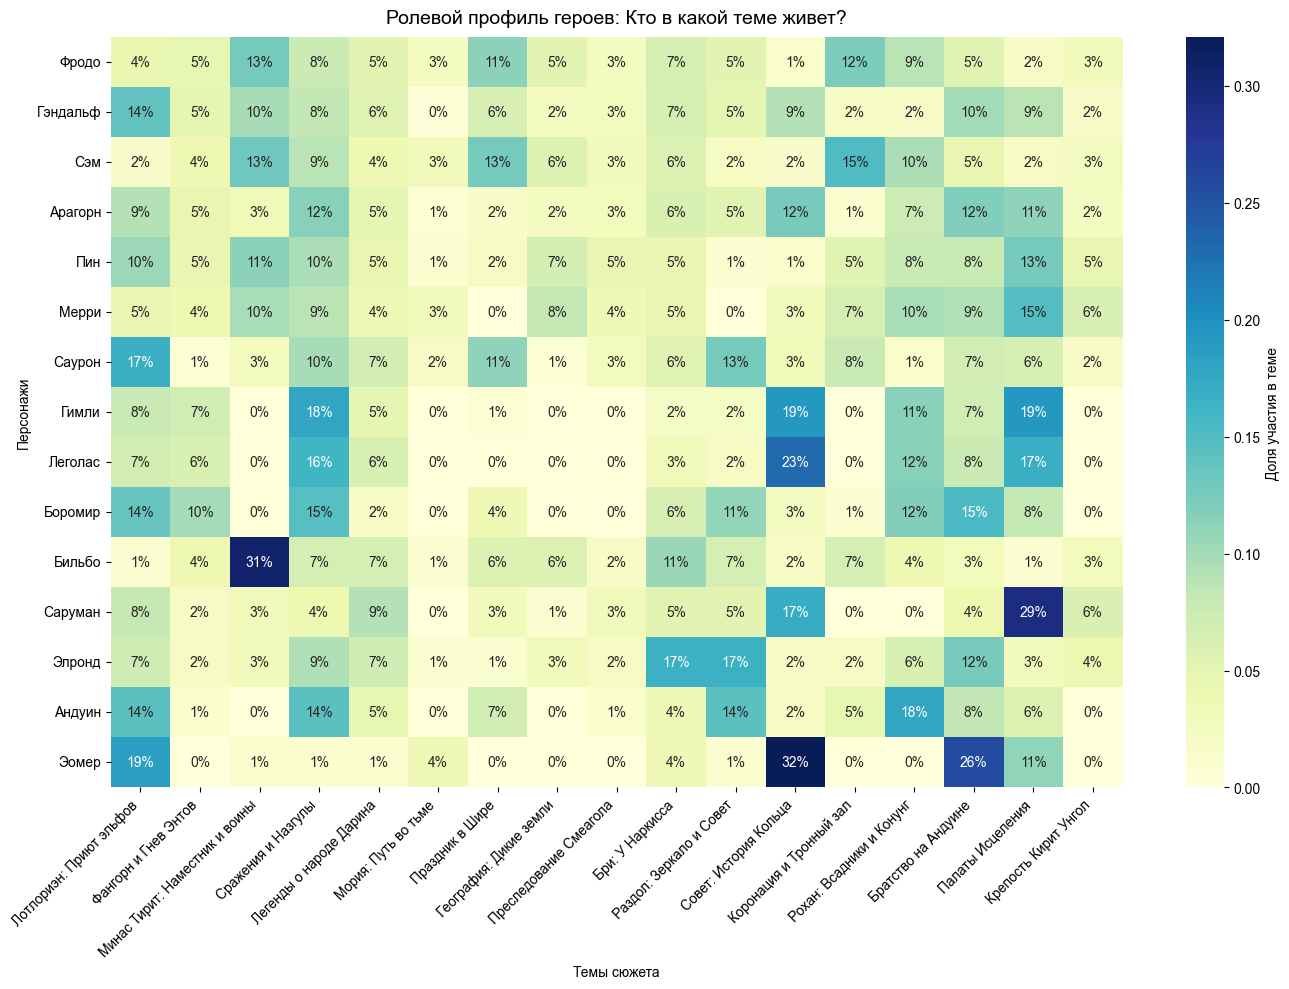

In [21]:
# Посмотрим, как часто герои встречаются в той или иной теме

def plot_hero_heatmap(df, topic_names):
    # Берем топ-15 героев для графика
    top_n_df = df.head(15).copy()
    
    # Оставляем только колонки с данными тем (Topic_0, Topic_1...)
    topic_cols = [c for c in df.columns if c.startswith('Topic_')]
    
    # Данные для отрисовки
    heatmap_data = top_n_df[topic_cols].values
    y_labels = top_n_df['Герой'].values

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    plt.figure(figsize=(14, 10))
    
    # Рисуем
    sns.heatmap(heatmap_data, 
                annot=True,       # Показать цифры
                fmt=".0%",        # В формате процентов
                cmap="YlGnBu",
                xticklabels=topic_names, 
                yticklabels=y_labels,
                cbar_kws={'label': 'Доля участия в теме'})
    
    plt.title('Ролевой профиль героев: Кто в какой теме живет?', fontsize=14, pad=10)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Темы сюжета')
    plt.ylabel('Персонажи')
    
    plt.tight_layout()
    plt.show()

plot_hero_heatmap(df_heroes, topic_names)

In [22]:
# Сохраняем модель
full_lda_model.save('full_lda_model.model')

data_to_pass_to_part3 = {
    'topic_matrix': topic_matrix,
    'topic_names': topic_names,
    'full_id2word': full_id2word,
    'full_corpus': full_corpus,
    'processed_segments': processed_segments, 
    'segments': segments,
    'book1_end': idx1,
    'book2_end': idx2,
    'chapter_start_indices': chapter_to_chunk_indices 
}

with open('global_model_results.pkl', 'wb') as f:
    pickle.dump(data_to_pass_to_part3, f)